In [1]:
import os
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn_extra.cluster import KMedoids

from sklearn.neighbors import NearestNeighbors

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
df= pd.read_csv("Data/Concatenated Features/by_year_features.csv")
df= df.fillna(0)
df.head()

,indeks,(SubTotal),Przepisy długoterminowe,Amortyzacja i straż pożarna,Kapitał partnerstwa głównego,Akcje mniejszościowe,Przepisy zadłużenia,Żywe istoty,Zachęta państwowa i pomoc,Zwiększenie wartości fundusze,...,Zobowiązania długoterminowe,Inne dochody i wydatki przed opodatkowaniem,Yab. Money Trans. Różnica. Efekt. Poprzedni.nak.ve nak. Tak jak. Wzrost/spadek netto,Sprzedaż zagraniczna,Sprzedaż krajowa,Akcje zysków/strat inwestycji cenianych metodą samowystarczalności,Samo -właściwość,Źródło_pliku,Nazwa,Rok
0,Yıllık,4.524640e+08,678404.0,1242248.0,1.387926e+08,0.0,2852756.0,0.0,0.0,0.0,...,2806817.0,449296.0,-9990337.0,0.0,0.0,0.0,1.387926e+08,A1CAP_2020.xlsx,A1CAP,2020
1,Yıllık,8.515088e+08,0.0,3263754.0,2.966258e+08,0.0,6670834.0,0.0,0.0,0.0,...,8695590.0,777230.0,121976765.0,0.0,0.0,0.0,2.966258e+08,A1CAP_2021.xlsx,A1CAP,2021
2,Yıllık,4.019261e+09,4748296.0,12651941.0,1.487849e+09,0.0,70752251.0,0.0,0.0,0.0,...,132279622.0,17107575.0,463136619.0,0.0,0.0,0.0,1.487849e+09,A1CAP_2022.xlsx,A1CAP,2022
3,Yıllık,6.297396e+09,7715324.0,21452328.0,3.696944e+09,0.0,42331251.0,0.0,0.0,0.0,...,34025698.0,6055765.0,691863980.0,0.0,0.0,0.0,3.696944e+09,A1CAP_2023.xlsx,A1CAP,2023
4,Yıllık,8.297508e+09,9773361.0,31826374.0,4.065838e+09,0.0,28062814.0,0.0,0.0,0.0,...,160295553.0,5169826.0,369461172.0,0.0,0.0,0.0,4.065838e+09,A1CAP_2024.xlsx,A1CAP,2024


In [3]:
# 2. Usuń 'indeks', jeśli istnieje
df = df.drop(columns=['indeks', 'Źródło_pliku'], errors='ignore')

# 3. Identyfikator i rok
id_col = 'Nazwa'
rok_col = 'Rok'

# 4. Przekształcenie: iterujemy po wszystkich kolumnach oprócz 'Nazwa' i 'Rok'
value_cols = [col for col in df.columns if col not in [id_col, rok_col]]

# 5. Tworzymy nowy DataFrame z odpowiednio nazwanymi kolumnami
dfs = []
for col in value_cols:
    temp = df[[id_col, rok_col, col]].copy()
    temp.columns = [id_col, rok_col, 'wartość']
    temp['kolumna'] = f"{col}"
    temp['nazwa_cechy_rok'] = temp['kolumna'] + '_' + temp[rok_col].astype(str)
    dfs.append(temp[[id_col, 'nazwa_cechy_rok', 'wartość']])

# 6. Scal wszystkie fragmenty
df_long = pd.concat(dfs, axis=0)

# 7. Pivot do formatu szerokiego
df_wide = df_long.pivot_table(
    index=id_col,
    columns='nazwa_cechy_rok',
    values='wartość',
    aggfunc='first'
).reset_index()

# 8. Spłaszcz kolumny
df_wide.columns.name = None

# 9. Podgląd
df_wide.head()

,Nazwa,(Głównie poza działalnością) Koszty finansowe (-)_2008,(Głównie poza działalnością) Koszty finansowe (-)_2009,(Głównie poza działalnością) Koszty finansowe (-)_2010,(Głównie poza działalnością) Koszty finansowe (-)_2011,(Głównie poza działalnością) Koszty finansowe (-)_2012,(Głównie poza działalnością) Koszty finansowe (-)_2013,(Głównie poza działalnością) Koszty finansowe (-)_2014,(Głównie poza działalnością) Koszty finansowe (-)_2015,(Głównie poza działalnością) Koszty finansowe (-)_2016,...,Żywe istoty_2015,Żywe istoty_2016,Żywe istoty_2017,Żywe istoty_2018,Żywe istoty_2019,Żywe istoty_2020,Żywe istoty_2021,Żywe istoty_2022,Żywe istoty_2023,Żywe istoty_2024
0,A1CAP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
1,ACSEL,NaN,NaN,-146658.0,0.0,-186001.0,-261542.0,-261542.0,-299978.0,-30594.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ADEL,-4467984.0,-4467984.0,-2562968.0,-2482437.0,-4188750.0,-5540038.0,-5540038.0,-28096595.0,-25598000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ADESE,NaN,NaN,-10952999.0,-12097631.0,-22325339.0,-8613300.0,-8613300.0,-20467422.0,-34318313.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ADGYO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0


In [4]:
def nan_procent_przedzial_dla_roku(df: pd.DataFrame, rok: int):
    rok_str = f"_{rok}"
    kolumny = [col for col in df.columns if rok_str in col]
    
    if not kolumny:
        print(f"Rok {rok}: brak kolumn.")
        return
    
    # Oblicz procent NaN w kolumnach danego roku
    nan_pct = df[kolumny].isna().mean() * 100
    
    min_nan = nan_pct.min()
    max_nan = nan_pct.max()
    
    if min_nan == max_nan:
        print(f"Rok {rok}: jednolity udział NaN = {min_nan:.2f}%")
    else:
        print(f"Rok {rok}: udział NaN w kolumnach od {min_nan:.2f}% do {max_nan:.2f}%")


for rok in range(2007, 2026):
    nan_procent_przedzial_dla_roku(df_wide, rok)

Rok 2007: brak kolumn.
Rok 2008: jednolity udział NaN = 59.10%
Rok 2009: jednolity udział NaN = 59.10%
Rok 2010: jednolity udział NaN = 47.21%
Rok 2011: jednolity udział NaN = 44.14%
Rok 2012: jednolity udział NaN = 41.44%
Rok 2013: jednolity udział NaN = 38.74%
Rok 2014: jednolity udział NaN = 38.74%
Rok 2015: jednolity udział NaN = 36.76%
Rok 2016: jednolity udział NaN = 35.14%
Rok 2017: jednolity udział NaN = 32.97%
Rok 2018: jednolity udział NaN = 22.52%
Rok 2019: jednolity udział NaN = 15.50%
Rok 2020: jednolity udział NaN = 8.11%
Rok 2021: jednolity udział NaN = 0.36%
Rok 2022: jednolity udział NaN = 0.00%
Rok 2023: jednolity udział NaN = 0.00%
Rok 2024: jednolity udział NaN = 0.36%
Rok 2025: brak kolumn.


In [5]:
# Parametry usuwania lat
rok_min = 2008
rok_max = 2023

def zawiera_rok_z_przedzialu(col_name, rok_min, rok_max):
    match = re.search(r'_(\d{4})', col_name)
    if match:
        rok = int(match.group(1))
        return rok_min <= rok <= rok_max
    return False

# Oddziel kolumnę identyfikatora
identyfikatory = df_wide['Nazwa']

# Usuń kolumnę 'Nazwa' i usuń kolumny z latami w przedziale
df_features = df_wide.drop(columns=['Nazwa'])
cols_to_drop = [col for col in df_features.columns if zawiera_rok_z_przedzialu(col, rok_min, rok_max)]
df_features_filtered = df_features.drop(columns=cols_to_drop)

# Uzupełnij NaN zerami (jeśli jeszcze są)
df_features_filtered = df_features_filtered.fillna(0)

# --- Standaryzacja ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features_filtered)

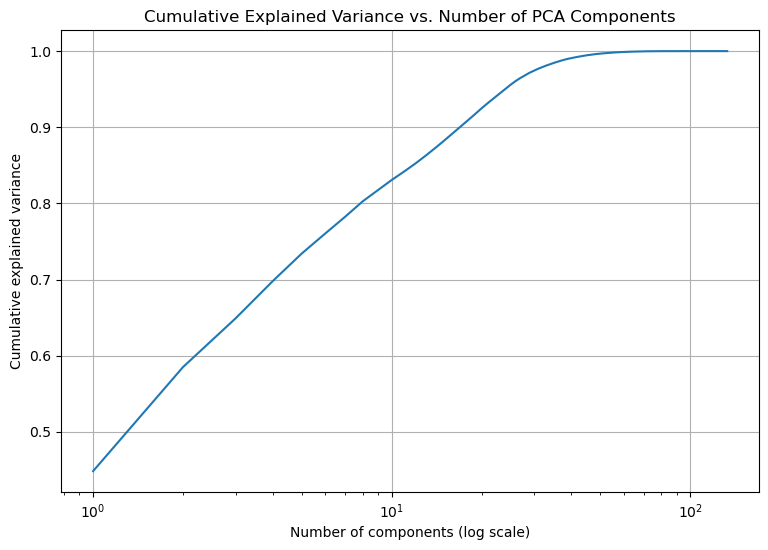

In [6]:
pca =  PCA().fit(X_scaled)

plt.figure(figsize=(9, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
plt.xscale('log')  # Skala logarytmiczna na osi X
plt.xlabel('Number of components (log scale)')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative Explained Variance vs. Number of PCA Components')
plt.grid(True)
plt.show()

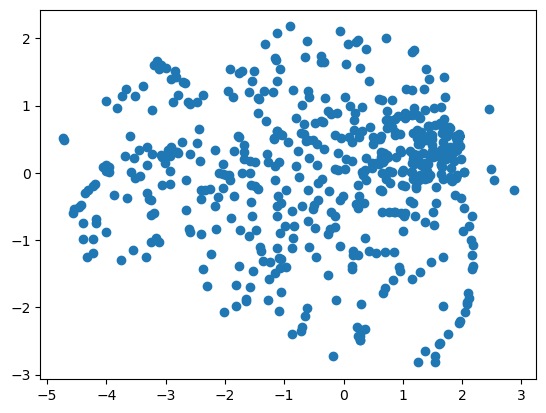

In [7]:
pca = PCA(n_components=0.8)  # Zachowaj tyle komponentów, aby wyjaśnić ...% wariancji
X_pca = pca.fit_transform(X_scaled)


# --- t-SNE ---
tsne = TSNE(n_components=2, perplexity=250, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()

In [8]:
# --- Klasteryzacje ---
n_clusters = 5 #dla funkcji które wymagają
results = {}
labels_dict = {}

In [9]:
def evaluate_clustering(X, labels, name):
    sil = silhouette_score(X, labels)
    db = davies_bouldin_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    return {"Method": name, "Silhouette": sil, "Davies-Bouldin": db, "Calinski-Harabasz": ch}

In [10]:
# KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)
results["KMeans"] = evaluate_clustering(X_pca, kmeans_labels, "KMeans")
labels_dict["KMeans"] = kmeans_labels

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [11]:
# Agglomerative Clustering
linkages = ['ward', 'complete', 'average', 'single' ]
for linkage in linkages:
    try:
        agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        agglo_labels = agglo.fit_predict(X_pca)
        results[f"Agglomerative ({linkage})"] = evaluate_clustering(X_scaled, agglo_labels, f"Agglomerative-{linkage}")
        labels_dict[f"Agglomerative ({linkage})"] = agglo_labels
    except Exception as e:
        print(f"Linkage '{linkage}' nie działa: {e}")

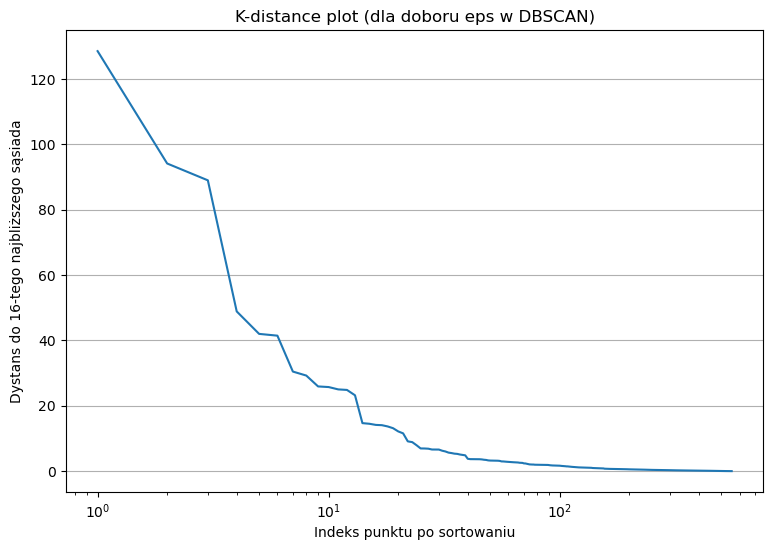

In [12]:
minPts = 2 * X_pca.shape[1]  # min_samples
nbrs = NearestNeighbors(n_neighbors=minPts).fit(X_pca)
distances, indices = nbrs.kneighbors(X_pca)

# Posortuj dystanse do minPts-tego sąsiada
distanceDec = sorted(distances[:, minPts - 1], reverse=True)

# Wykres
fig = plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(111)
ax1.plot(range(1, X_pca.shape[0] + 1), distanceDec)

plt.xlabel('Indeks punktu po sortowaniu')
plt.ylabel(f'Dystans do {minPts}-tego najbliższego sąsiada')
plt.xscale('log')
plt.grid(axis='y')
plt.title('K-distance plot (dla doboru eps w DBSCAN)')
plt.show()

In [13]:
# DBSCAN
dbscan = DBSCAN(eps=35,   min_samples= 2*X_pca.shape[1])
dbscan_labels = dbscan.fit_predict(X_pca)
if len(set(dbscan_labels)) > 1 and len(set(dbscan_labels)) < len(X_pca):
    results["DBSCAN"] = evaluate_clustering(X_scaled, dbscan_labels, "DBSCAN")
    labels_dict["DBSCAN"] = dbscan_labels

In [14]:
# Gaussian Mixture
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm_labels = gmm.fit_predict(X_pca)
results["GMM"] = evaluate_clustering(X_scaled, gmm_labels, "GMM")
labels_dict["GMM"] = gmm_labels

In [15]:
# KMedoids
medoid_metrics = ['euclidean', 'manhattan', 'cosine']
for metric in medoid_metrics:
    try:
        kmedoids = KMedoids(n_clusters=n_clusters, metric=metric, random_state=42)
        kmedoids_labels = kmedoids.fit_predict(X_pca)
        results[f"KMedoids ({metric})"] = evaluate_clustering(X_pca, kmedoids_labels, f"KMedoids-{metric}")
        labels_dict[f"KMedoids ({metric})"] = kmedoids_labels
    except Exception as e:
        print(f"Metryka '{metric}' nie powiodła się: {e}")

In [16]:
# --- Tabela wyników ---
results_df = pd.DataFrame(results).T.sort_values(by="Silhouette", ascending=False)
print("\nOcena metod klasteryzacji:")
print(results_df)


Ocena metod klasteryzacji:
                                          Method Silhouette Davies-Bouldin  \
DBSCAN                                    DBSCAN   0.930704       1.086964   
KMeans                                    KMeans    0.89413       0.526742   
Agglomerative (complete)  Agglomerative-complete   0.884341       0.049875   
Agglomerative (average)    Agglomerative-average   0.884341       0.049875   
Agglomerative (single)      Agglomerative-single   0.884341       0.049875   
Agglomerative (ward)          Agglomerative-ward   0.837193       0.729225   
GMM                                          GMM   0.529203       1.393916   
KMedoids (cosine)                KMedoids-cosine   0.259975       1.877836   
KMedoids (euclidean)          KMedoids-euclidean   0.013552       1.733761   
KMedoids (manhattan)          KMedoids-manhattan  -0.098851       2.530474   

                         Calinski-Harabasz  
DBSCAN                          213.177696  
KMeans                 

In [17]:
# --- Funkcja do wizualizacji ---
def plot_embedding(X_embedded, method_name, labels_dict):
    n = len(labels_dict)
    cols = 3
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()
    for i, (name, labels) in enumerate(labels_dict.items()):
        ax = axes[i]
        sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=labels, palette='tab10', ax=ax, s=40, alpha = 0.5, legend='full')
        ax.set_title(f"{name} ({method_name})")
        ax.set_xlabel(f"{method_name} 1")
        ax.set_ylabel(f"{method_name} 2")
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

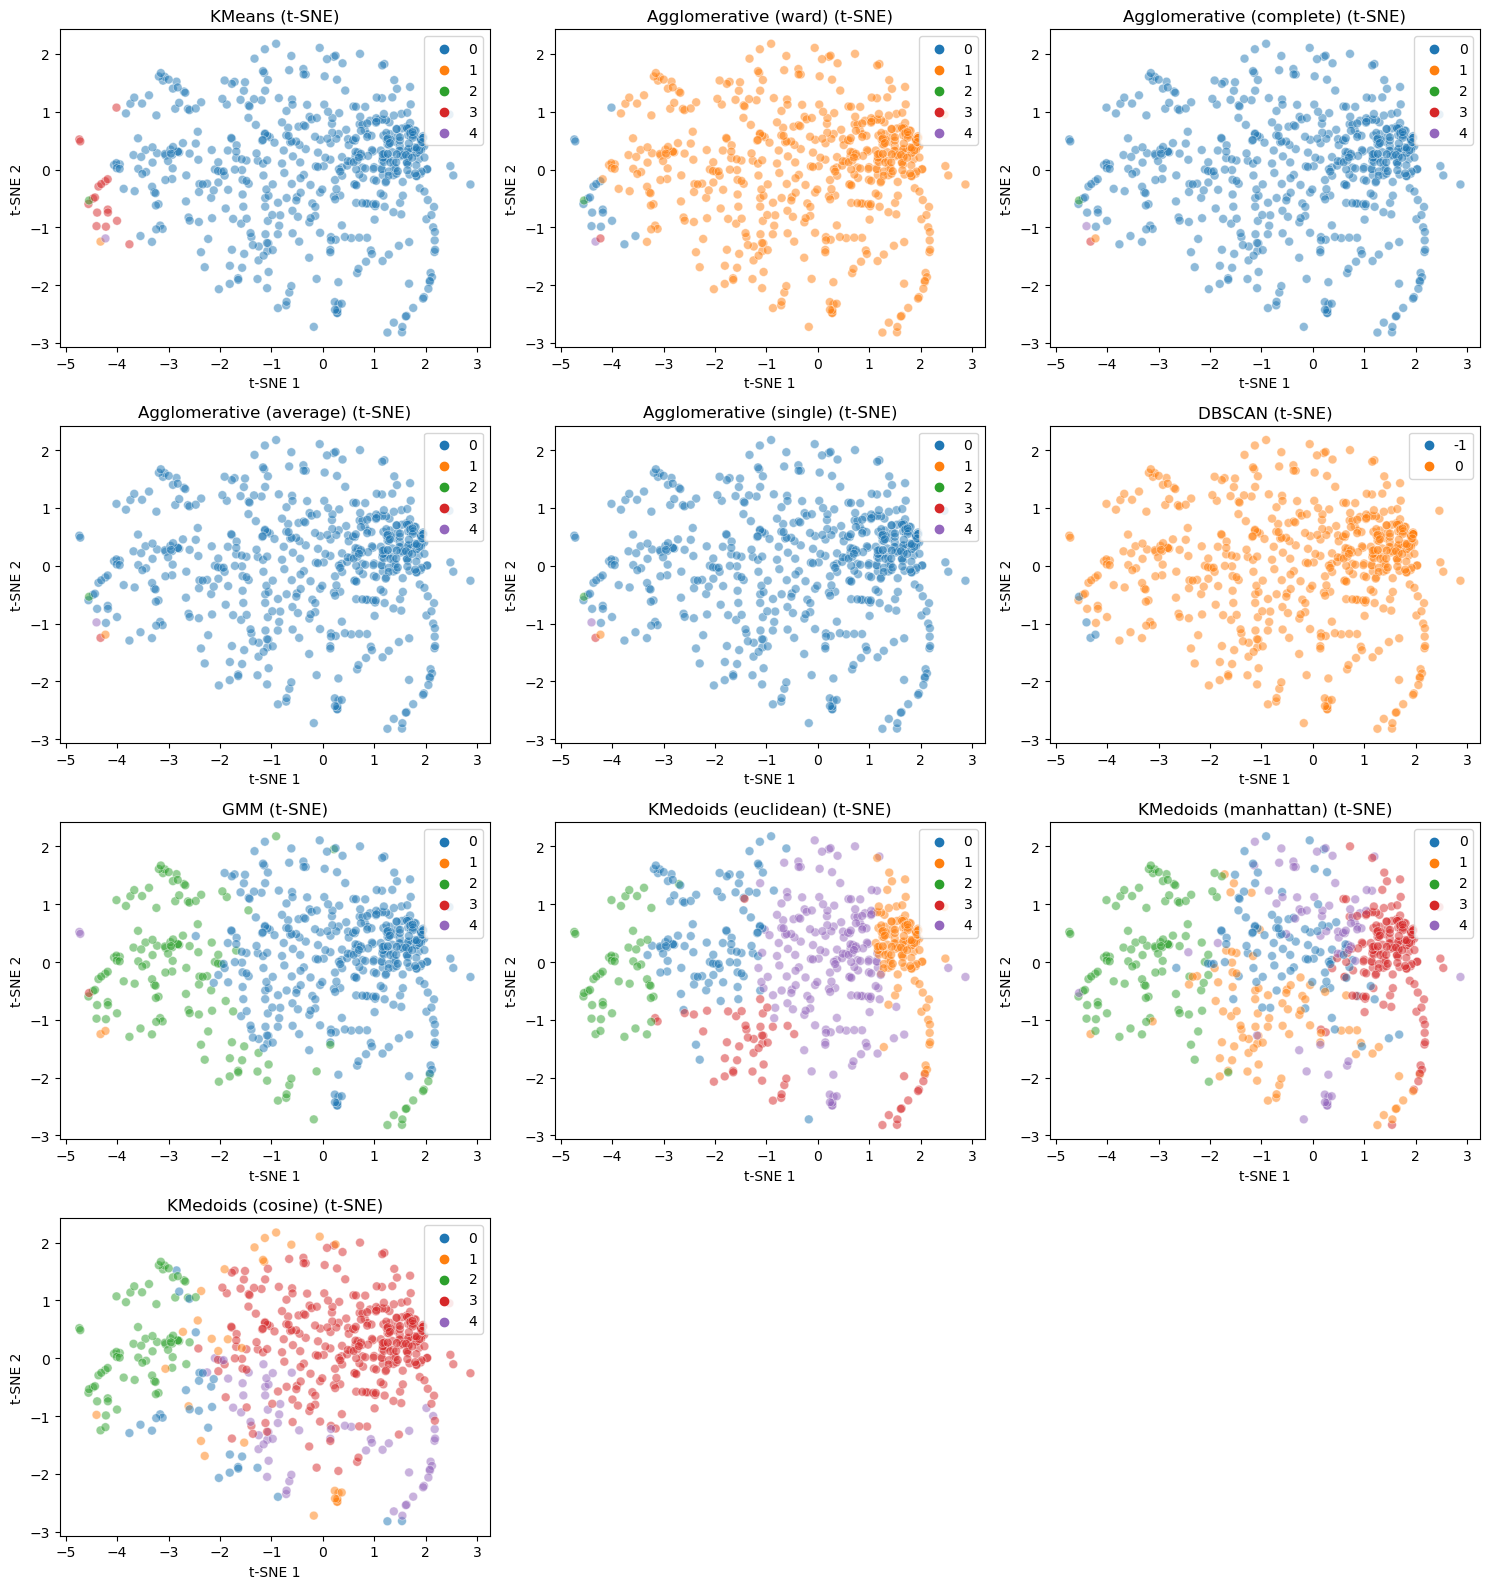

In [18]:
# --- Wizualizacja t-SNE z klastrami ---
plot_embedding(X_tsne, "t-SNE", labels_dict)

In [19]:
# Funkcja do wizualizacji średnich i wariancji cech wewnątrz klastrów

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def wrap_labels(labels, width=35):
    return ['\n'.join([label[i:i+width] for i in range(0, len(label), width)]) for label in labels]

class ShiftScaleLogNorm(mcolors.Normalize):
    def __init__(self, vmin=None, vmax=None, clip=False, scale_min=1, scale_max=8):
        super().__init__(vmin, vmax, clip)
        self.scale_min = scale_min
        self.scale_max = scale_max

    def __call__(self, value, clip=None):
        value = np.array(value, copy=True)
        vmin, vmax = self.vmin, self.vmax
        # Liniowe skalowanie z [vmin,vmax] do [scale_min, scale_max]
        scaled = (value - vmin) / (vmax - vmin) * (self.scale_max - self.scale_min) + self.scale_min
        # Przycinanie, żeby nie było wartości poniżej scale_min
        scaled = np.clip(scaled, self.scale_min, self.scale_max)
        # Normalizacja logarytmiczna do zakresu [0,1]
        log_scaled = (np.log10(scaled) - np.log10(self.scale_min)) / (np.log10(self.scale_max) - np.log10(self.scale_min))
        return log_scaled

    def inverse(self, value):
        log_val = value * (np.log10(self.scale_max) - np.log10(self.scale_min)) + np.log10(self.scale_min)
        scaled = 10**log_val
        vmin, vmax = self.vmin, self.vmax
        orig = (scaled - self.scale_min) / (self.scale_max - self.scale_min) * (vmax - vmin) + vmin
        return orig

def cluster_summary(
    df_orig: pd.DataFrame,
    df_cluster: pd.DataFrame,
    cluster_labels: pd.Series,
    cluster_col: str = None
) -> pd.DataFrame:
    # 1. Przygotowanie etykiet klastrów
    if cluster_col is not None:
        labels = df_orig[cluster_col] if cluster_col in df_orig else df_cluster[cluster_col]
    else:
        labels = pd.Series(cluster_labels, index=df_orig.index, name='cluster')

    # 2. Statystyki globalne
    global_mean = df_orig.mean()
    global_var = df_orig.var()

    # 3. Statystyki per klaster
    grouped = df_orig.assign(cluster=labels).groupby('cluster')
    cluster_means = grouped.mean()
    cluster_vars = grouped.var()

    # 4. Tabela wyników
    rows = []
    for feat in df_orig.columns:
        row = {
            'feature': feat,
            'global_mean': global_mean[feat],
            'global_var': global_var[feat]
        }
        for cl in cluster_means.index:
            row[f'mean_cluster_{cl}'] = cluster_means.loc[cl, feat]
            row[f'var_cluster_{cl}'] = cluster_vars.loc[cl, feat]
        rows.append(row)
    summary_df = pd.DataFrame(rows).set_index('feature')

    # 5. Przygotowanie etykiet
    feats = df_orig.columns
    wrapped_feats = wrap_labels(feats, width=35)

    # === PRZYGOTOWANIE ===
    mean_vals = cluster_means.values.flatten()
    var_vals = cluster_vars.values.flatten()
    mean_norm = ShiftScaleLogNorm(vmin=mean_vals.min(), vmax=mean_vals.max(), scale_min=1, scale_max=8)
    var_norm = ShiftScaleLogNorm(vmin=var_vals.min(), vmax=var_vals.max(), scale_min=1, scale_max=8)
    
    fig, axes = plt.subplots(1, 4, figsize=(24, max(6, 0.4 * len(feats))),
                             gridspec_kw={'width_ratios': [1, 3, 1, 3]},
                             constrained_layout=True)
    
    # === MAPA ŚREDNICH ===
    sns.heatmap(global_mean.to_frame(name="Global"), cmap='viridis', norm=mean_norm,
                annot=True, fmt=".2f", cbar=False, ax=axes[0])
    axes[0].set_title("Globalna średnia")
    axes[0].set_ylabel("")
    axes[0].set_xlabel("")
    axes[0].set_yticklabels(wrapped_feats, rotation=0, fontsize=9)
    
    sns.heatmap(cluster_means.T, annot=True, fmt=".2f", ax=axes[1],
                cmap='viridis', norm=mean_norm, cbar=False)
    axes[1].set_title('Średnie w klastrach')
    axes[1].set_xlabel('Klaster')
    axes[1].set_ylabel("")
    axes[1].set_yticklabels([])  # <-- ukryj etykiety osi Y
    
    # === MAPA WARIANCJI ===
    sns.heatmap(global_var.to_frame(name="Global"), cmap='magma', norm=var_norm,
                annot=True, fmt=".2f", cbar=False, ax=axes[2])
    axes[2].set_title("Globalna wariancja")
    axes[2].set_xlabel("")
    axes[2].set_ylabel("")
    axes[2].set_yticklabels([])  # <-- ukryj etykiety osi Y
    
    sns.heatmap(cluster_vars.T, annot=True, fmt=".2f", ax=axes[3],
                cmap='magma', norm=var_norm, cbar=False)
    axes[3].set_title('Wariancje w klastrach')
    axes[3].set_xlabel('Klaster')
    axes[3].set_ylabel("")
    axes[3].set_yticklabels([])  # <-- ukryj etykiety osi Y
    
    plt.show()

    return summary_df



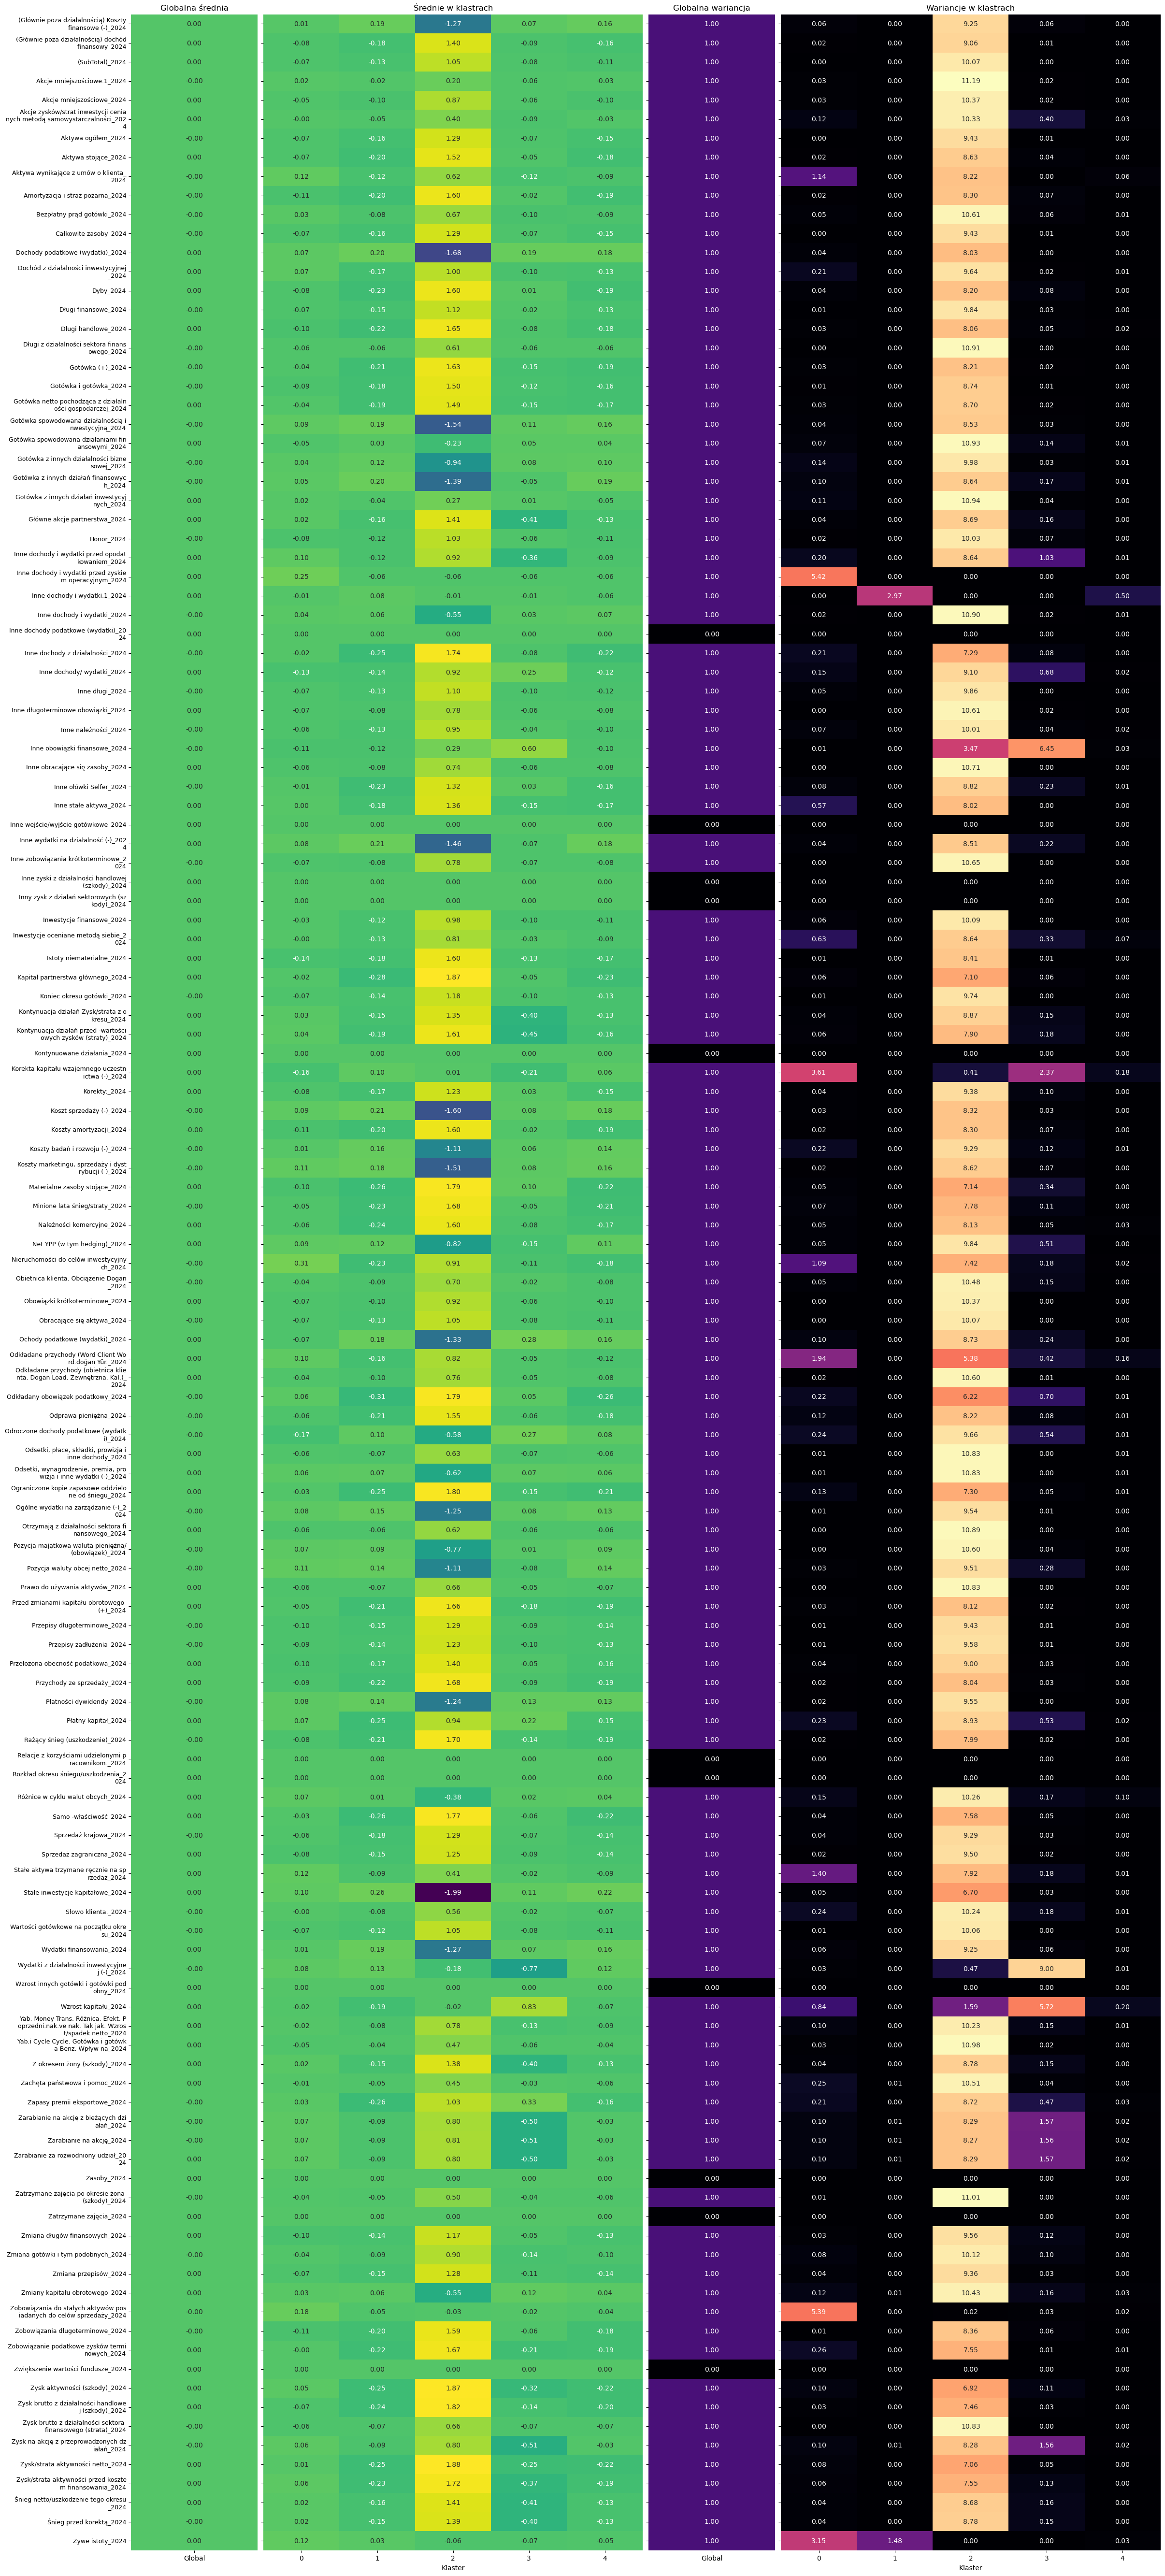

In [20]:
# 1. Zamień X_scaled na DataFrame z oryginalnymi nazwami cech
df_scaled = pd.DataFrame(X_scaled, columns=df_features_filtered.columns, index=df_features_filtered.index)

# 2. Zamień X_pca na DataFrame (dla indeksów)
df_pca = pd.DataFrame(X_pca, index=df_scaled.index, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

# 3. Etykiety klastrów jako Series
_series = pd.Series(labels_dict['KMedoids (euclidean)'], index=df_scaled.index, name="cluster")

# 4. Wywołanie analizy
_summary = cluster_summary(
    df_orig=df_scaled,       # <-- cechy z nazwami
    df_cluster=df_pca,       # <-- tylko dla zachowania indeksów
    cluster_labels=_series
)
